In [3]:
import numpy as np             
import pandas as pd  #Python Data Analysis Library handle data in a user friendly way
import scipy as sc
import matplotlib.pyplot as plt #for plots
import seaborn as sns # for better plots
%matplotlib inline
from sklearn import linear_model # A very popular Python library for Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #needed to for assessing prediction
from sklearn import datasets ## imports datasets from scikit-learn
import statsmodels.api as sm

We will begin with generating data.

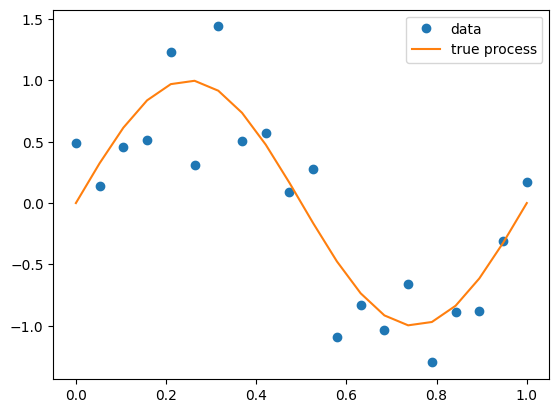

In [4]:
#Polynomial fitting exercises
np.random.seed(1)
n = 20 #number of points
x = np.linspace(0, 1, n)
f = np.sin(2*np.pi*x)
y = f+0.3*np.random.randn(n)
#plt.plot(xg,f,label='true process')
plt.plot(x,y,'o',label='data')
plt.plot(x,f,label='true process')
plt.legend()

We put x,y into the pandas dataframe called data. Also put a vector of ones as x0.

In [5]:
x0 = np.ones(n)
data = pd.DataFrame(np.column_stack([y,x0,x]),columns=['y','x0','x']) 
#Expand the data including powers of x up to 10
for i in range(2,11):  #executes the following indented commands for i varying from 3 to 9
    colname = 'x%d'%i # the %d %i puts a different number in the name of each variable
    data[colname] = data['x']**i #raise to the power of i
    # the for loop continues until the first time a command is not indented.
data.head()

,y,x0,x,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0.487304,1.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.141173,1.0,0.052632,0.002770,0.000146,0.000008,4.038611e-07,2.125585e-08,1.118729e-09,5.888046e-11,3.098972e-12,1.631038e-13
2,0.455761,1.0,0.105263,0.011080,0.001166,0.000123,1.292355e-05,1.360374e-06,1.431973e-07,1.507340e-08,1.586673e-09,1.670183e-10
3,0.515276,1.0,0.157895,0.024931,0.003936,0.000622,9.813824e-05,1.549551e-05,2.446660e-06,3.863147e-07,6.099706e-08,9.631114e-09
4,1.229023,1.0,0.210526,0.044321,0.009331,0.001964,4.135537e-04,8.706395e-05,1.832925e-05,3.858790e-06,8.123768e-07,1.710267e-07


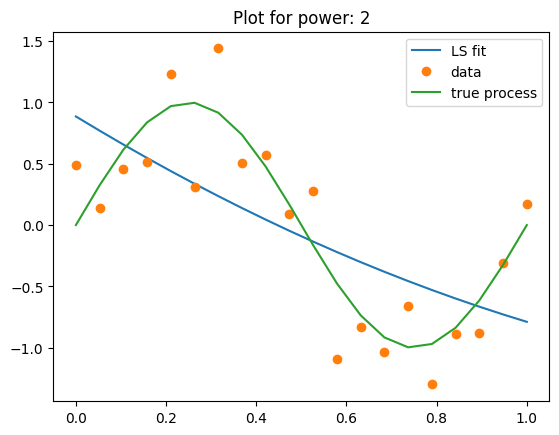

In [6]:
npower = 2
predictors = ['x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
linreg = LinearRegression(fit_intercept=True)
linreg.fit(data[predictors],data['y'])
y_pred = linreg.predict(data[predictors])
plt.plot(data['x'],y_pred, label='LS fit')
plt.plot(data['x'],data['y'],'o',label='data')
plt.plot(x,f,label='true process')
plt.title('Plot for power: %d'%npower)
plt.legend()

### Matrix operations

Below we find the MLE without the scikit linear regression function. For that we

1. Form the design matrix $X$ and the response vector y
2. Calculate the MLE as $$\hat{\beta} = (X^T X)^{-1}X^T y$$

The code below does that and also prints $X^T X$ and $(X^T X)^{-1}$ for checking.

In [7]:
npower = 2
predictors = ['x0','x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
X = data[predictors]
y = data['y']
XtX = X.T.dot(X) #X.T give X transpose X.dot(b) does matrix multiplication X*b
XtX_inv = sc.linalg.inv(XtX) #sc.linalg.inv(A) provide the inverse of A
beta = XtX_inv.dot(X.T.dot(y))
XtX, XtX_inv, beta

(           x0          x        x2
 x0  20.000000  10.000000  6.842105
 x   10.000000   6.842105  5.263158
 x2   6.842105   5.263158  4.317539,
 array([[ 0.37077922, -1.44350649,  1.17207792],
        [-1.44350649,  7.96601732, -7.42316017],
        [ 1.17207792, -7.42316017,  7.42316017]]),
 array([ 0.88516511, -2.23262046,  0.55870444]))

Check the $\beta$ you found with the scikit function:

In [8]:
print('Beta scikit', linreg.intercept_, linreg.coef_)

Beta scikit 0.885165107953048 [-2.23262046  0.55870444]


We can go beyond the point estimate and calculate the variance of $\hat{\beta}$.

The code below provides $\hat{\sigma}^2$, the covariance matrix $$\text{var}[\hat{\beta}] = \hat{\sigma}^2 (X^T X)^{-1}, $$
and its diagonal.

In [9]:
n,p = X.shape
e = y - X.dot(beta)# beta is your derived MLE coefficents in the previous cells
sigma2_hat = e.T.dot(e)/(n-p)
var_beta = sigma2_hat*(sc.linalg.inv(X.T.dot(X)))
sigma2_hat, var_beta, np.diag(var_beta)

(0.3881246982512338,
 array([[ 0.14390857, -0.56026052,  0.45491239],
        [-0.56026052,  3.09180807, -2.8811118 ],
        [ 0.45491239, -2.8811118 ,  2.8811118 ]]),
 array([0.14390857, 3.09180807, 2.8811118 ]))

With the above quantities we can calculate confidence intervals for MLE's. For those we will need the 97.5\% point of the $t_{n-p}$ distribution. 

The following code does that and also puts the results in pandas dataframe.

In [10]:
#calculate 95% CI for beta and present output via a pandas data frame 
tval = sc.stats.t.ppf(0.975,n-p)
std_beta = np.sqrt(np.diag(var_beta))
lower95 = beta - tval*std_beta
upper95 = beta + tval*std_beta
results = np.column_stack([beta,std_beta,lower95,upper95])
col = ['coefficient','se','lower 95% bound','upper 95% bound']
ind = ['intercept','x','x2']
results = pd.DataFrame(results,columns = col,index=ind)
results

,coefficient,se,lower 95% bound,upper 95% bound
intercept,0.885165,0.379353,0.084801,1.685530
x,-2.232620,1.758354,-5.942423,1.477182
x2,0.558704,1.697384,-3.022462,4.139871


To check our answers we also use the relevant function (.OLS) of the library **statsmodels**  

In [11]:
Poly = ['x','x2']
X = data[Poly]
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     6.704
Date:                Wed, 15 Nov 2023   Prob (F-statistic):            0.00714
Time:                        21:12:01   Log-Likelihood:                -17.289
No. Observations:                  20   AIC:                             40.58
Df Residuals:                      17   BIC:                             43.57
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8852      0.379      2.333      0.032       0.085       1.686
x             -2.2326      1.758     -1.270      0.221      -5.942       1.477
x2             0.5587      1.697      0.329      0.746      -3.022       4.140
==============================================================================
Omnibus:                        1.146   Durbin-Watson:                   1.109
Prob(Omnibus):                  0.564   Jarque-Bera (JB):                1.040
Skew:                           0.412   Prob(JB):                        0.595
Kurtosis:                       2.245   Cond. No.                         20.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the following cells:
1. Obtain the MLEs and 95\% confidence intervals for the 3rd order polynomial without using any Python built in function. 
2. Check your answers against the statsmodels corresponding function (.OLS)

In [12]:
cubic = ['x0','x','x2','x3']
X = data[cubic]

XtX_inv = sc.linalg.inv(X.T @ X)
beta = XtX_inv.dot(X.T.dot(y))

e = y - X.dot(beta)
n, p = X.shape

var_data = (e.T @ e) / (n-p)
var_beta = var_data * XtX_inv
std_beta = np.diag(var_beta)**0.5
print(var_data)


t_val = sc.stats.t.ppf(0.975,n-p)
lower_95 = beta - t_val * std_beta
upper_95 = beta + t_val * std_beta

results = np.column_stack([beta,std_beta,lower_95,upper_95])
col = ['coefficient','se','lower 95% bound','upper 95% bound']
ind = ['intercept','x','x2','x3']
results = pd.DataFrame(results,columns = col,index=ind)
results


0.15058878555441896


,coefficient,se,lower 95% bound,upper 95% bound
intercept,-0.010460,0.290987,-0.627324,0.606404
x,10.124663,2.586393,4.641755,15.607572
x2,-31.139397,6.102501,-44.076122,-18.202672
x3,21.132068,4.006810,12.638011,29.626125


In [13]:
Poly = ['x','x2','x3']
X = data[Poly]
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     20.79
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           9.12e-06
Time:                        21:12:09   Log-Likelihood:                -7.2153
No. Observations:                  20   AIC:                             22.43
Df Residuals:                      16   BIC:                             26.41
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0105      0.291     -0.036      0.972      -0.627       0.606
x             10.1247      2.586      3.915      0.001       4.642      15.608
x2           -31.1394      6.103     -5.103      0.000     -44.076     -18.203
x3            21.1321      4.007      5.274      0.000      12.638      29.626
==============================================================================
Omnibus:                        0.301   Durbin-Watson:                   2.750
Prob(Omnibus):                  0.860   Jarque-Bera (JB):                0.470
Skew:                           0.142   Prob(JB):                        0.790
Kurtosis:                       2.305   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We will now put all the previous talk into a function. In other words we will create our own function rather than using the stasmodels/scikit learn ones. 

The inputs of the function will be $X$, $y$ and the names of the predictors. The output will be a data frame with the results (MLE's, se's and 95\% CI's).

Write this function  below.

In [15]:
def MLE(X, y, pred):

    XtX_inv = sc.linalg.inv(X.T @ X)
    beta = XtX_inv.dot(X.T.dot(y))

    e = y - X.dot(beta)
    n, p = X.shape

    var_data = (e.T @ e) / (n-p)
    var_beta = var_data * XtX_inv
    std_beta = np.diag(var_beta)**0.5

    t_val = sc.stats.t.ppf(0.975,n-p)
    lower_95 = beta - t_val * std_beta
    upper_95 = beta + t_val * std_beta

    results = np.column_stack([beta,std_beta,lower_95,upper_95])
    col = ['coefficient','se','lower 95% bound','upper 95% bound']
    ind = ['intercept', pred[1]]
    npower = len(pred)-1
    ind.extend([pred[1]+'%d'%i for i in range(2,npower+1)])
    results = pd.DataFrame(results,columns = col,index=ind)
    
    return results

pred = ['x0','x','x2','x3']
X = data[pred]
y = data['y']
result = MLE(X, y, pred)
result


,coefficient,se,lower 95% bound,upper 95% bound
intercept,-0.010460,0.290987,-0.627324,0.606404
x,10.124663,2.586393,4.641755,15.607572
x2,-31.139397,6.102501,-44.076122,-18.202672
x3,21.132068,4.006810,12.638011,29.626125


### Bayesian Linear Regression

We now turn to Bayesian inference. As before we will illustrate and then create a function that provides summaries of the posterior (Bayes estimates of $\beta$ and 95\% Credible Intervals).

We start by calculating the posterior parameters that correspond to the unit information prior.

Given $\sigma^2$ and a **prior** of N($\mu_0,\sigma^2\Omega_0)$, the **posterior** $\pi(\beta|X,y,\sigma^2)$ is N($\mu_n,\sigma^2\Omega_n^2$) where

$$\mu_n = (X^T X+\Omega_0^{-1})^{-1} (\Omega_0^{-1}\mu_0 +X^{T}y)$$
$$\Omega_n =(X^T X +\Omega_0^{-1})^{-1}$$

To assign the unit information prior we set $\Omega_0 = n(X^T X)^{-1}$ or else $\Omega_0^{-1}=X^T X / n$.

For $\sigma^2$ if we set the **prior** IGamma $(a_0,b_0)$ we get the **posterior** IGamma $(a_n,b_n)$ where
$$
a_n = a_0+\frac{n}{2}
$$
$$
b_n = b_0+\frac{1}{2} (y^T y + \mu_0^T\Omega_0^{-1}\mu_0 +\mu_n^T\Omega_n^{-1}\mu_n).
$$

Calculate posterior parameters in the following cell

In [16]:
def get_post_param(X, y):

    n, p = X.shape
    XtX = X.T.dot(X)

    a_0 = 0.01
    b_0 = 0.01

    Omega_0_inv = XtX / n
    Omega_0 = n * np.linalg.inv(XtX)

    Omega_n_inv = (XtX + Omega_0_inv)
    Omega_n = np.linalg.inv(Omega_n_inv)

    mu_0 = np.zeros(p)
    mu_n = Omega_n.dot(Omega_0_inv.dot(mu_0) + X.T.dot(y))

    a_n = a_0 + n/2
    b_n = b_0 + 1/2 * (y.T.dot(y) + mu_0.T.dot(Omega_0_inv).dot(mu_0) + mu_n.T.dot(Omega_n_inv).dot(mu_n))

    return mu_n, Omega_n, a_n, b_n

pred = ['x0','x','x2']
X = data[pred]
mu_n, Omega_n, a_n, b_n = get_post_param(X, y)
print('mu_n:', mu_n, '\nOmega_n:', Omega_n, '\na_n:', a_n, '\nb_n:', b_n)

mu_n: [ 0.84301439 -2.1263052   0.53209947] 
Omega_n: [[ 0.35312307 -1.37476809  1.11626469]
 [-1.37476809  7.58668316 -7.06967636]
 [ 1.11626469 -7.06967636  7.06967636]] 
a_n: 10.01 
b_n: 8.420037312650457


#### Monte Carlo for credible intervals

To obtain credible intervals for $\beta$ we could use the $t$ distribution. But we would use Monte Carlo instead as this will cover more general models. e.g. logistic regression.

So we will sample $N$ Monte Carlo samples from $\pi(\beta|y)$ and use them  for Monte Carlo inference (credible intervals, density plots etc)

Monte Carlo Samples can be drawn by

1. Generating samples $\sigma_i^2$ from IGamma $(\alpha_n,\beta_n)$, $i=1,\dots,N$,
2. Draw $\beta_i$ sample based on each $\sigma_i^2$ from N($\mu_n,\sigma^2\Omega_n^2$)

In [17]:
#Calculate 95% credible intervals
N = 10000 #number of Monte Carlo samples
sigma2 = 1/np.random.gamma(a_n, 1/b_n, N)
betas = np.zeros((N,p))

# draw N samples from the marginal posterior of beta
for i in range(0,N):
    s2 =sigma2[i]
    cov = s2*Om_n
    betas[i,] = np.random.multivariate_normal(mu_n,cov,1)

#find the mean of each column which corresponds to each beta coefficient     
mu_beta = np.mean(betas, axis=0)

#find the 2.5 and 97.5 percentils which correspond to each beta coefficient 
lower95 = np.percentile(betas,2.5,axis=0)
upper95 = np.percentile(betas,97.5,axis=0)
mu_beta, lower95, upper95

NameError: name 'Om_n' is not defined

As before we put it all in a function. This is quite handy as it is hard to find such a function in Python!!

In [18]:
# function for Bayesian Linear regression, return posterior mean and 95% CIs
def BLR(X,y,mu_0,Om_0_inv,a_0,b_0,ind_names,N):

    col_names = ['posterior mean','lower 95% bound','upper 95% bound']
    
    n,p = X.shape
    XtX = X.T.dot(X)
    
    Om_n_inv = XtX + Om_0_inv
    Om_n = sc.linalg.inv(Om_n_inv)

    term1 = Om_0_inv.dot(mu_0)+X.T.dot(y)
    mu_n = Om_n.dot(term1)

    a_n = a_0 + n/2

    term2 = y.T.dot(y)+mu_0.dot(Om_0_inv.dot(mu_0))-mu_n.T.dot(Om_n_inv.dot(mu_n))
    b_n = b_0 + term2/2

    sigma2 = 1/np.random.gamma(a_n, 1/b_n, N)
    betas = np.zeros((N,p))

    # draw N samples from the marginal posterior of beta
    for i in range(0,N):
        s2 = sigma2[i]
        cov = s2*Om_n
        betas[i,] = np.random.multivariate_normal(mu_n,cov,1)

    #find the mean of each column which corresponds to each beta coefficient     
    mu_beta = np.mean(betas, axis=0)
    #find the 2.5 and 97.5 percentils which correspond to each beta coefficient 
    lower95 = np.percentile(betas,2.5,axis=0)
    upper95 = np.percentile(betas,97.5,axis=0)
    results = np.column_stack([mu_beta,lower95,upper95])
    results = pd.DataFrame(results,columns = col_names,index=ind_names)

    return results, mu_n, Om_n, a_n, b_n

### Marginal likelihood / Model Evidence

Finally we will calculate the marginal likelihood / model evidence of a given model. We will use the following trick covered in the lecture

We can write
$$
\pi(\beta,\sigma^2|y,X)=\frac{\pi(y|\beta,\sigma^2,X)\pi(\beta,\sigma^2)}{\pi(y|X)},
$$
or else
$$
\pi(y|X)=\frac{\pi(y|\beta,\sigma^2,X)\pi(\beta,\sigma^2)}{\pi(\beta,\sigma^2|y,X)},
$$
for all $\beta, \sigma^2$.

The expression above contains known Normal and Inverse Gamma pdfs so we can just evaluate for -say- the posterior mean of $\beta$, $\sigma^2$.

The calculation involves the following steps

1. Specify data and prior
2. get the parameters of the posteriod distribution
3. evaluate the log-likelihood, log-prior and log-posterior at the posterior mean
4. The log-evidence is equal to log-likelihood + log-prior - log-posterior

In [19]:
# Step 1
npower = 3
predictors = ['x0','x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
X = data[predictors]
y = data['y']
n,p = X.shape

# Step 2
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior
a_0 = 0.1
b_0 = 0.1
N=10000 #Monte Carlo sample size
results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)

# Step 3
# evaluate log-likelihood
beta = mu_n
sigma2 = b_n/(a_n-1)
Om_0 = sc.linalg.inv(Om_0_inv)
mu = X.dot(beta)
cov = sigma2*np.eye(n)
ll = sc.stats.multivariate_normal.logpdf(y,mu,cov)
# evaluate log-prior
lprior = a_0*np.log(b_0) - sc.special.loggamma(a_0) - (a_0+1)*np.log(sigma2) - b_0/sigma2 # typo? -(a-1)?
lprior = lprior + sc.stats.multivariate_normal.logpdf(beta,mu_0,sigma2*Om_0)
# evaluate log-posterior
lpost = a_n*np.log(b_n) - sc.special.loggamma(a_n) - (a_n+1)*np.log(sigma2) - b_n/sigma2
lpost = lpost + sc.stats.multivariate_normal.logpdf(beta,mu_n,sigma2*Om_n)

lmodevid = ll+lprior-lpost
lmodevid

-18.212515913838086

Let's make it a function. Again not easy to find such a function, keep it!

In [20]:
def ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0): 

    beta = mu_n
    sigma2 = b_n/(a_n-1)

    Om_0 = sc.linalg.inv(Om_0_inv)
    mu = X.dot(beta)
    
    cov = sigma2*np.eye(X.shape[0])
    ll = sc.stats.multivariate_normal.logpdf(y,mu,cov)

    # evaluate log-prior
    lprior = a_0*np.log(b_0) - sc.special.loggamma(a_0) - (a_0+1)*np.log(sigma2) - b_0/sigma2
    lprior = lprior + sc.stats.multivariate_normal.logpdf(beta,mu_0,sigma2*Om_0)

    # evaluate log-posterior
    lpost = a_n*np.log(b_n) - sc.special.loggamma(a_n) - (a_n+1)*np.log(sigma2) - b_n/sigma2
    lpost = lpost +sc.stats.multivariate_normal.logpdf(beta,mu_n,sigma2*Om_n)
    lmodevid = ll+lprior-lpost

    return lmodevid

Now to get the evidence for a model we can simply use the code below

In [21]:
# Data
npower = 2
predictors = ['x0','x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
X = data[predictors]
y = data['y']
n,p = X.shape

# Prior
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior
a_0 = 0.1
b_0 = 0.1

# Calculation
N=10000 #Monte Carlo sample size
results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
lmodevid = ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)
lmodevid

-25.122117003562536

Consider polynomials from order 2 to 6. Find the order of polynomial with the highest model evidence.

In [22]:
for npower in range (2, 7):

    # Data
    predictors = ['x0','x']
    predictors.extend(['x%d'%i for i in range(2,npower+1)])
    X = data[predictors]
    y = data['y']
    n,p = X.shape

    # Prior
    mu_0 = np.zeros(p)
    XtX = X.T.dot(X)
    Om_0_inv = XtX/n #unit information prior
    a_0 = 0.1
    b_0 = 0.1

    # Calculation
    N=10000 #Monte Carlo sample size
    results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
    lmodevid = ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)
    print('Polynomial:', npower, lmodevid)

Polynomial: 2 -25.122117003562536
Polynomial: 3 -18.212515913838086
Polynomial: 4 -18.93575902878517
Polynomial: 5 -19.24634385232043
Polynomial: 6 -20.42774020969665


### Autmobile Bodily Injury Claims Data

Source: Insurance Research Council (IRC)

The data are automobile injury claims data using data from the Insurance Research Council (IRC), a division of the American Institute for Chartered Property Casualty Underwriters and the Insurance Institute of America. The data, collected in 2002, contains information on the gender of the claimant, attorney involvement, years of driving experience and the economic loss (LOSS, in thousands). A detailed description of the variables in the data is provided below:

- Attorney: Whether the claimant is represented by an attorney (=1 if yes and =0 if no)
- CLMSEX: Claimant’s gender (=1 if male and =0 if female 
- CLMAGE: Claimant’s age minus the age driving license was obtained
- LOSS: The claimant’s total economic loss (in thousands $)

For confidentiality issues we consider here a sample of  simulated data similar to that of a state is considered. 

The data are in the provided file 'automobileBI.csv'

In [23]:
Auto = pd.read_csv("automobileBI.csv")
intercept = np.ones(Auto.shape[0])
Auto.insert(0, 'INTERCEPT', intercept)
Auto.head()

,INTERCEPT,ATTORNEY,CLMSEX,CLMAGE,LOSS
0,1.0,1,0,1.8,6.38
1,1.0,0,0,5.6,0.95
2,1.0,1,1,1.4,1.88
3,1.0,0,1,5.4,0.11
4,1.0,1,0,0.9,6.95


In [24]:
Auto.describe()

,INTERCEPT,ATTORNEY,CLMSEX,CLMAGE,LOSS
count,1296.0,1296.000000,1296.000000,1296.000000,1296.000000
mean,1.0,0.510802,0.423611,4.885571,4.616821
std,0.0,0.500076,0.494321,4.586972,7.570060
min,1.0,0.000000,0.000000,0.100000,0.010000
25%,1.0,0.000000,0.000000,1.700000,0.637500
50%,1.0,1.000000,0.000000,3.300000,2.000000
75%,1.0,1.000000,1.000000,6.600000,5.227500
max,1.0,1.000000,1.000000,31.300000,76.170000


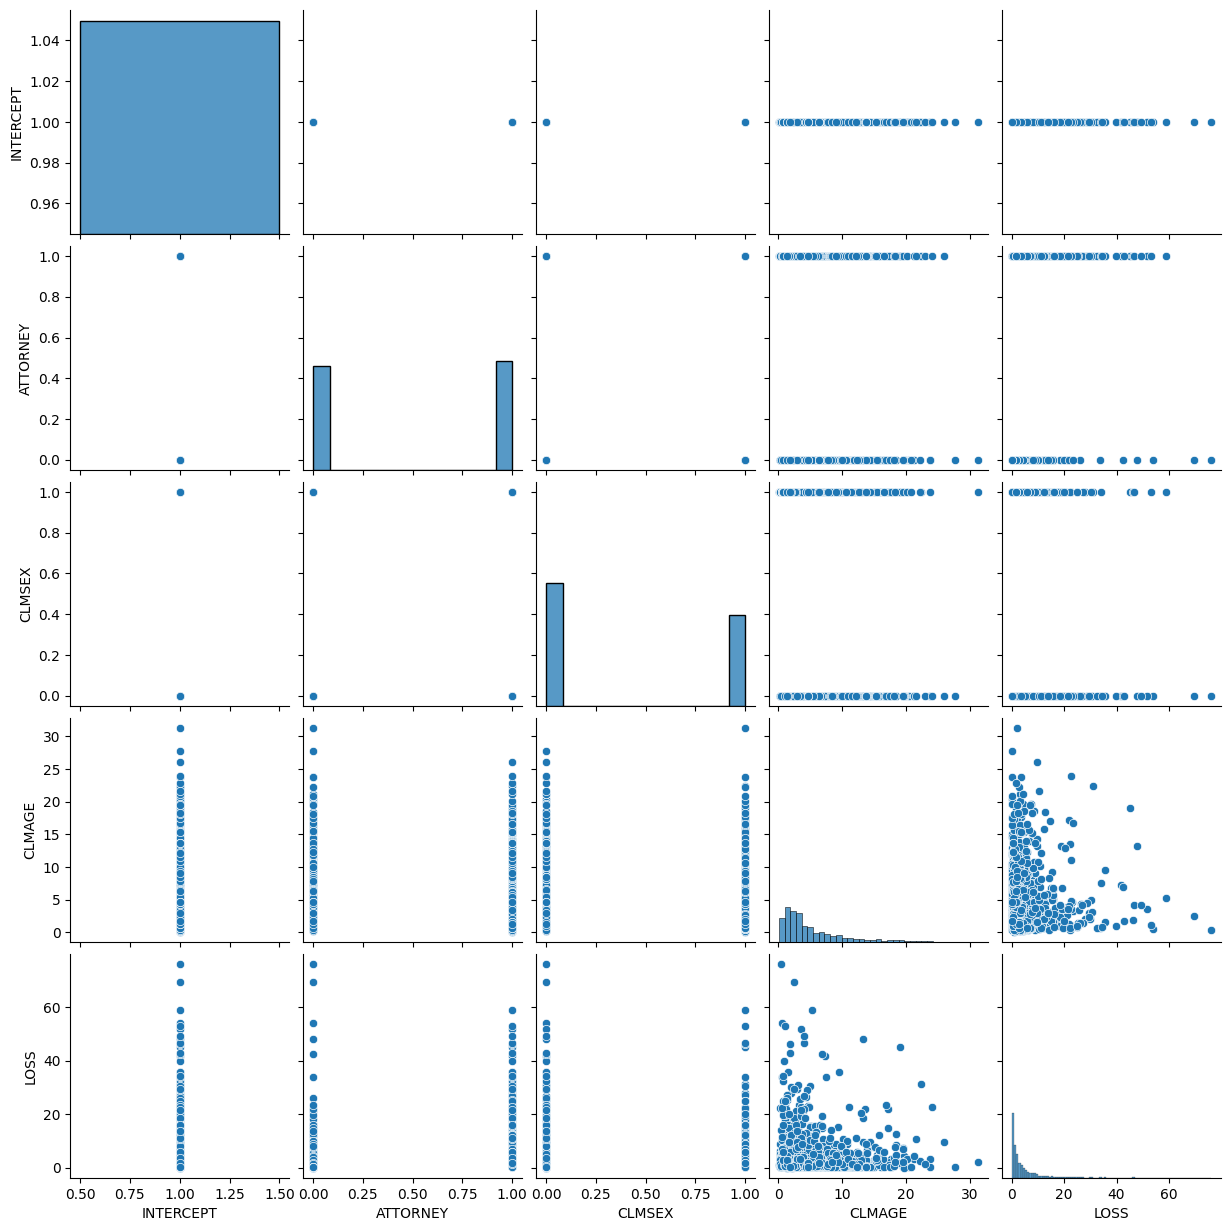

In [26]:
sns.pairplot(Auto)

Consider all possible regression models with the LOSS variable as response and some (or all or none) of the other variables present (in their current form, no polynomials). There are 8 such models.

Calculate the model evidence for each of them, report the optimal one and present posterior estimates of its coefficients.

In [25]:
pred_list = [
    ['INTERCEPT'],
    ['INTERCEPT','ATTORNEY'],
    ['INTERCEPT','CLMSEX'],
    ['INTERCEPT','CLMAGE'],
    ['INTERCEPT','ATTORNEY', 'CLMSEX'],
    ['INTERCEPT','ATTORNEY', 'CLMAGE'],
    ['INTERCEPT','CLMSEX', 'CLMAGE'],
    ['INTERCEPT','ATTORNEY', 'CLMSEX', 'CLMAGE'],
]

for pred in pred_list:
    X = Auto[pred]
    # X = sm.add_constant(Auto[list(pred)])
    y = Auto['LOSS']
    n,p = X.shape

    # Prior
    mu_0 = np.zeros(p)
    XtX = X.T.dot(X)
    Om_0_inv = XtX/n #unit information prior
    a_0 = 0.1
    b_0 = 0.1

    # Calculation
    N=10000 #Monte Carlo sample size
    results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,pred,N)
    lmodevid = ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)
    print(pred, '\nmu_n:', mu_n, '\nOm_n:', Om_n, '\na_n:', a_n, '\nb_n:', b_n, '\nlmodevid:', lmodevid, '\n\n')
    results

['INTERCEPT'] 
mu_n: [4.61326137] 
Om_n: [[0.00077101]] 
a_n: 648.1 
b_n: 37116.25855219738 
lmodevid: -4470.785914944492 


['INTERCEPT', 'ATTORNEY'] 
mu_n: [2.58935851 3.96220259] 
Om_n: [[ 0.00157607 -0.00157607]
 [-0.00157607  0.00308548]] 
a_n: 648.1 
b_n: 34572.23820661568 
lmodevid: -4428.352053578861 


['INTERCEPT', 'CLMSEX'] 
mu_n: [ 4.7255104  -0.26498131] 
Om_n: [[ 0.00133766 -0.00133766]
 [-0.00133766  0.00315775]] 
a_n: 648.1 
b_n: 37105.14063570628 
lmodevid: -4474.175656618392 


['INTERCEPT', 'CLMAGE'] 
mu_n: [ 4.85345889 -0.04916468] 
Om_n: [[ 1.64634403e-03 -1.79167185e-04]
 [-1.79167185e-04  3.66727217e-05]] 
a_n: 648.1 
b_n: 37083.302646744036 
lmodevid: -4473.794109292987 


['INTERCEPT', 'ATTORNEY', 'CLMSEX'] 
mu_n: [ 2.88589959  4.07771299 -0.83931717] 
Om_n: [[ 0.00197804 -0.00141949 -0.00113772]
 [-0.00141949  0.00314647 -0.00044317]
 [-0.00113772 -0.00044317  0.00322016]] 
a_n: 648.1 
b_n: 34462.85665166981 
lmodevid: -4429.882213036676 


['INTERCEPT', 'ATTO